In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'ravdess-emotional-speech-audio:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F107620%2F256618%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T172643Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D59863c4899e69ba2817fa0325b705ebccc21ff724087ff90f4178586a292fc0bc096340894f0c980681a58a5cc2340dbdfb799088652ffa51b7c780b6f160a2d6c6da762c4e100c030531646a499b5334d4289e91b4556928454b9415afe7a63540cd9820640b0780178b3b1d445c1779ea7929149cdb504c224857ad06268112263360278c2dcd56a9e56fb10ea8198ee25c8807830b8067a9c974dae1e21b7fd3d38c18230e6e98e1ddf5444b315f2c4e9085a8b3a3ab1702d2c9a9f790d107d652972d2f373a8e5193f9913e636fa2770a2dc6f48e82968a5f968e28aab58dc5a6019211a2f9f4613a1d090eeb67427d34e8bf6cbf6228c605ba8afabca53,toronto-emotional-speech-set-tess:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F316368%2F639622%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T172643Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D05f4f9e3b13c86fc70035adba332dbe6df3aab87b7a91cd877599e6ffb6ae82cd553fe54e7ca78e043d70f167bb574e3b0b224dd73480d34f39eb4e8ab7cbfb6560a8e1bab633db2aa24083a852d2bdbe5e2247414799e67a3492fca99192da6a74cc047b180f3f0a328080482d51b7b3d6b52e401aaec238db1ab63d553a321c5f99f43a4b7346010c6586cbdc8d869637a9b74b2be8a2d64c1d9ca4a9d77a4dd7e58ee9d0cd6c6b59e402a1472273d3068b3f7b8eb9a41fa51981e5ada1d698cbfca310f59ec679e3835864fec776165e74345e6aa9b016569f538960686dd9e523e74a326dc136a7a34e233cb8c8c55c53728ce05f8cb01cb7f32657ba6d0,cremad:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F325566%2F653195%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T172643Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D20392dd6c326a4b4174592e5330341d5e7d3688f61b0b547f5c3c03587bae443db7a62a8592fea5d3b992466f0ffb847139dcff1162e78f5dea20d01a8d665d698be9549d8e8b29fb1f164d523938f3d5d60433ff1355bb24ba33e017edb5c0a68a1d5221a084306e638751cab12bb3f536d2d470a9a26878a6db2a5abaf2cb83e5d3fef32c9193cc31ebfe6570005b99c8c15d8c032a5d1fc45b01a2dae354516e55bc063be173c44af9bbe315b46ecc54a8a9701489d3a6c27b93bcf3071bf3ef1c80e29857793e7fba68418638a576c3e63d85a2347478d90a42ee5bd9c2924128c54b373b6a0edb88186f58eaf5ab75405e0b2f8c17e56dbdd5ae36b9093,surrey-audiovisual-expressed-emotion-savee:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F338555%2F671851%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240327%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240327T172643Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4fe8a9198e04acb09d1fe6aab016c1d816026298cb85f929afe0f17632c770dedc473f8e327c94a57fcd26a190a81669540d8c1a37dab05002aa8a007d181ebee5b494d1911ed8fbbf6690a8a7d3917432ecd7cb4251596dfb889e8bb99f2726116ab803588800a0c2eb6c065550772716b85403af0cb8f6e91a6e92419128848e044f6c96ef7e4e53a5c1b768b2f1938594a3c1e4316b26a3d75a6bad743cf71fdb64ff65b17ec00f7a3e92566dfad1af303d2bf3b0d7f44670101558d4c0a5a4ee702f73e67a5d9c53fea1c2df0bb85246647d73cf2e480977da475bc8312f1c7b26fd4399ec135cd1cbab02344713afe79f6b3a7044acb95a7bac592764b6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 450102890 bytes downloaded
Downloaded and uncompressed: ravdess-emotional-speech-audio
[==================================================] 448572034 bytes downloaded
Downloaded and uncompressed: toronto-emotional-speech-set-tess
[==================================================] 473324524 bytes downloaded
Downloaded and uncompressed: cremad
[==================================================] 112690765 bytes downloaded
Downloaded and uncompressed: surrey-audiovisual-expressed-emotion-savee
Data source import complete.


#  <center> Speech Emotion Recognition <center>

# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [103]:
# Path for data.
Crema = "/kaggle/input/cremad/AudioWAV/"


## <center>2. Crema DataFrame</center>

In [179]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')



In [105]:
df = pd.DataFrame()
df['speech'] = file_path
df['label'] = file_emotion
df.head()

,speech,label
0,/kaggle/input/cremad/AudioWAV/1041_IEO_DIS_HI.wav,disgust
1,/kaggle/input/cremad/AudioWAV/1073_TSI_SAD_XX.wav,sad
2,/kaggle/input/cremad/AudioWAV/1021_IWW_HAP_XX.wav,happy
3,/kaggle/input/cremad/AudioWAV/1085_TAI_NEU_XX.wav,neutral
4,/kaggle/input/cremad/AudioWAV/1056_MTI_DIS_XX.wav,disgust


In [106]:
df['label'].value_counts()


disgust    1271
sad        1271
happy      1271
angry      1271
fear       1271
neutral    1087
Name: label, dtype: int64

<Axes: xlabel='label', ylabel='count'>

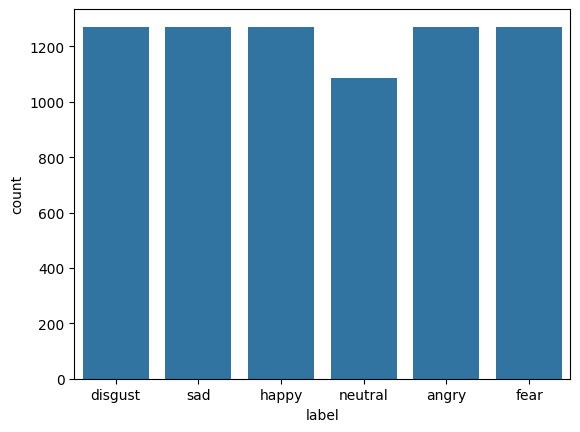

In [108]:
sns.countplot(x='label', data=df)


In [109]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

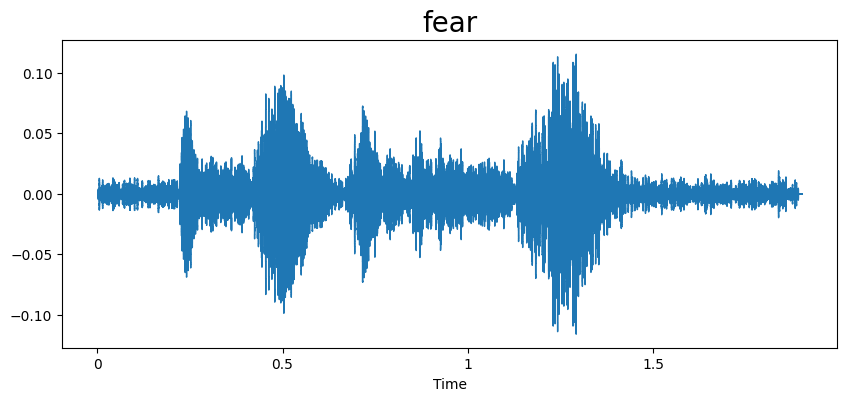

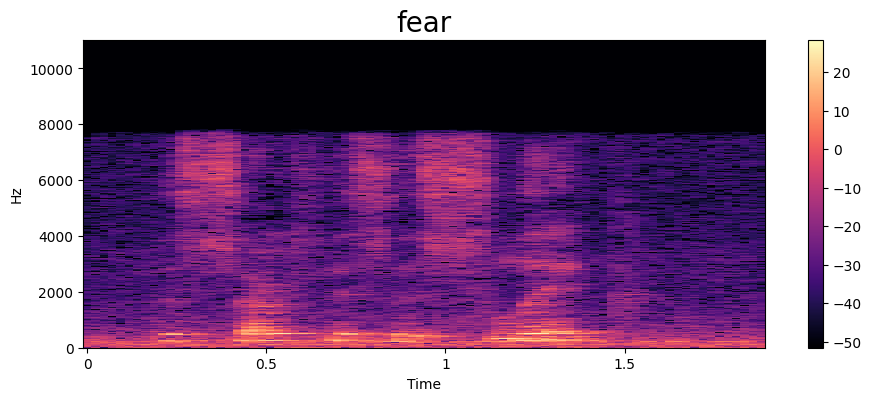

In [110]:
emotion = 'fear'
path = np.array(df['speech'][df['label']==emotion])[3]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)


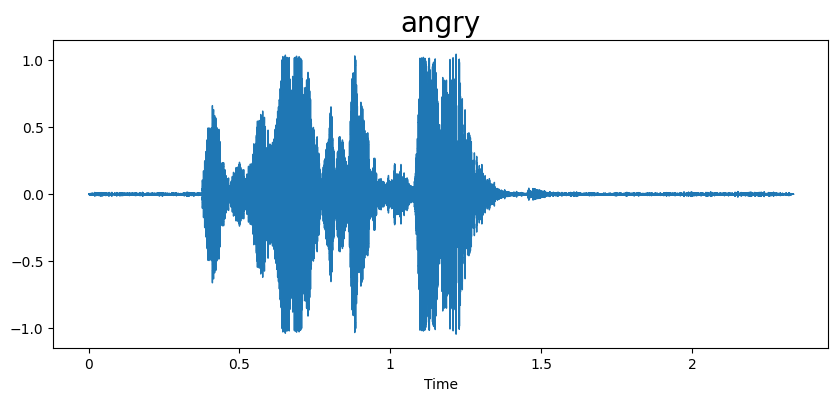

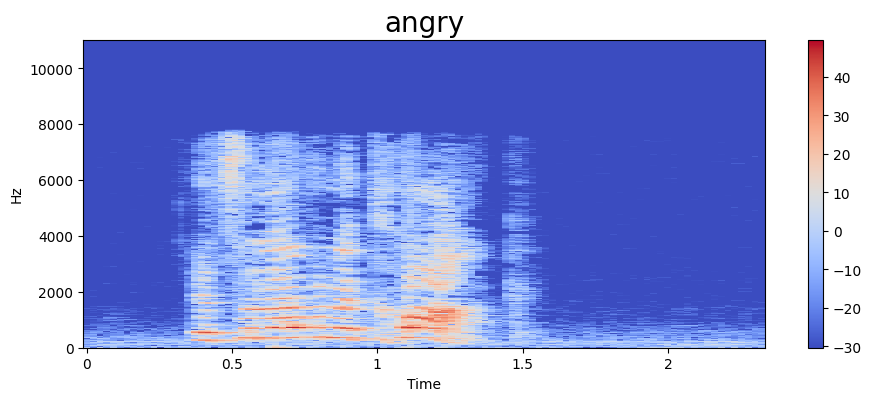

In [111]:
emotion = 'angry'
path = np.array(df['speech'][df['label']==emotion])[5]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

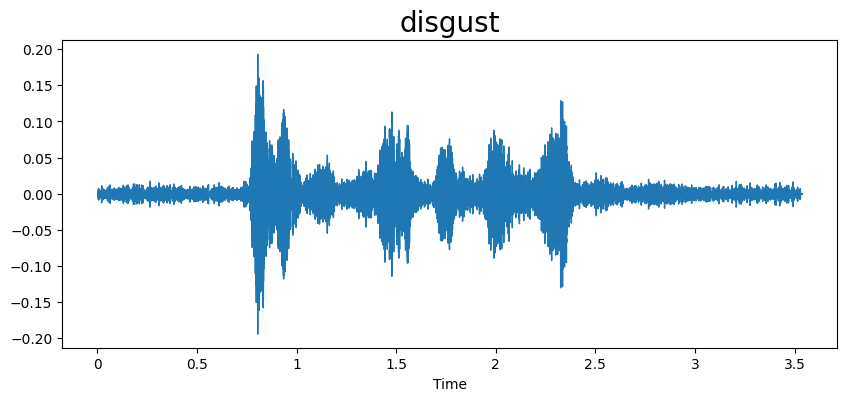

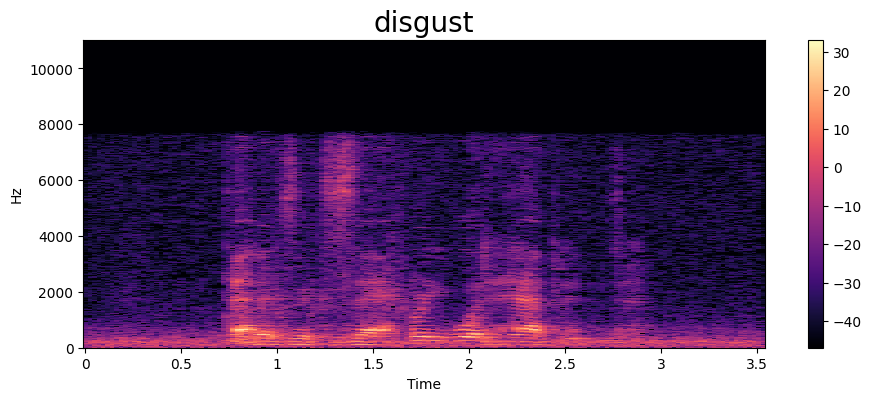

In [112]:
emotion = 'disgust'
path = np.array(df['speech'][df['label']==emotion])[7]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

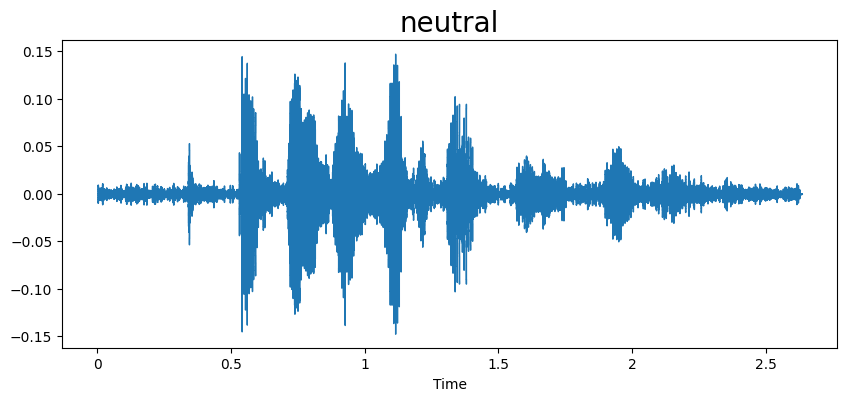

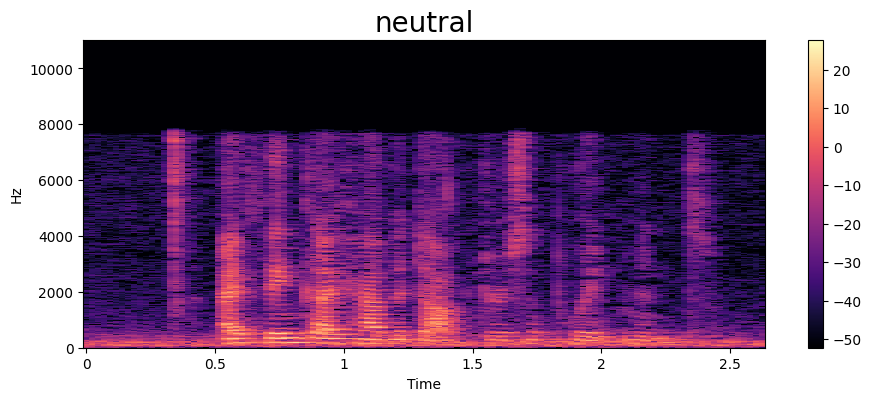

In [113]:
emotion = 'neutral'
path = np.array(df['speech'][df['label']==emotion])[2]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

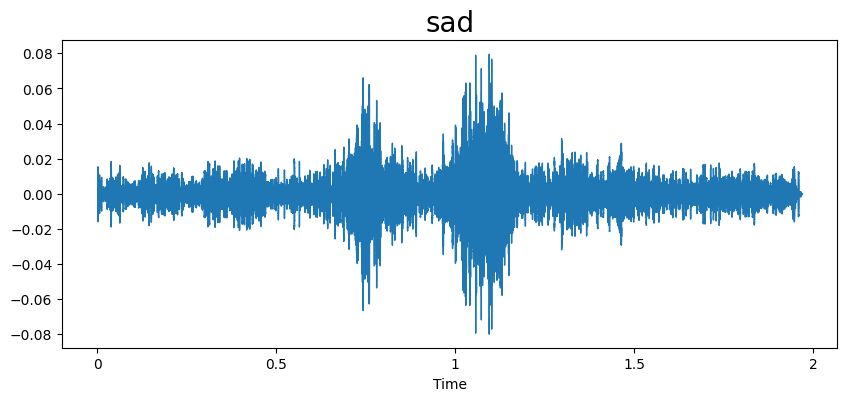

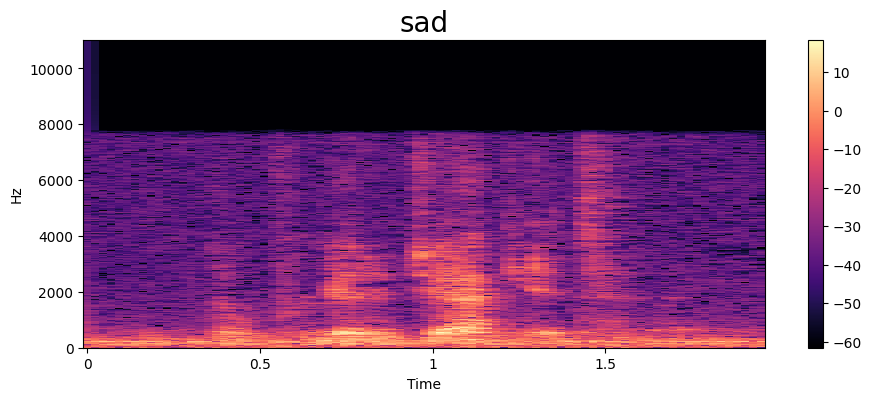

In [114]:
emotion = 'sad'
path = np.array(df['speech'][df['label']==emotion])[4]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

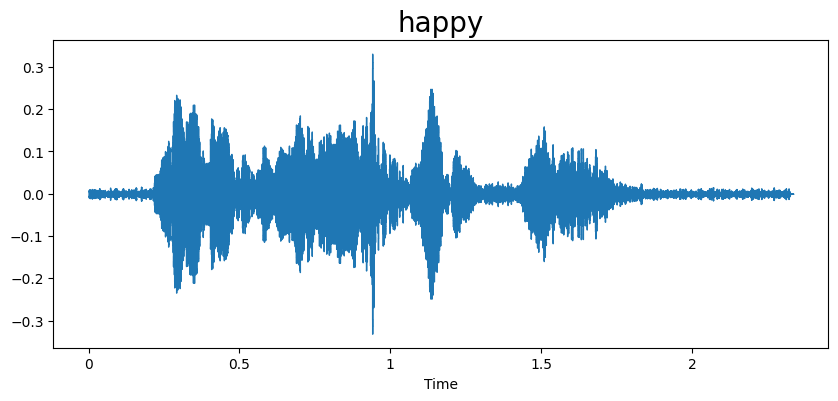

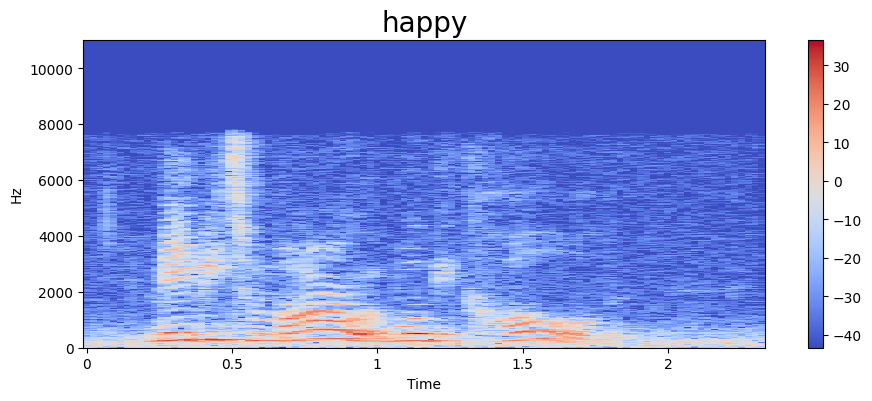

In [116]:
emotion = 'happy'
path = np.array(df['speech'][df['label']==emotion])[2]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [117]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [118]:
extract_mfcc(df['speech'][0])


array([-3.9001166e+02,  1.4439948e+02,  8.8591461e+00,  4.0026772e+01,
       -2.0859697e+01,  2.2307543e+01, -1.6317144e+01,  1.0922259e+01,
       -7.1625972e+00,  6.4657205e-01,  3.9653957e+00, -1.1301316e+00,
        5.4620352e+00, -9.5683603e+00,  6.2680101e+00, -5.6250834e+00,
       -7.3333120e-01, -7.6612654e+00, -1.4847037e-01, -6.5519600e+00,
       -2.2818606e+00,  1.5724036e+00, -4.2835002e+00,  6.1063128e+00,
       -2.2240174e+00,  4.0074425e+00, -3.2570934e+00, -2.0488791e+00,
       -3.6120691e+00,  6.2344867e-01,  1.4147449e+00,  1.9265470e-01,
        4.8731375e+00, -5.5729663e-01,  3.4944754e+00, -7.6955616e-01,
        3.7101120e-01, -3.3705552e+00, -6.8260276e-01,  1.0566527e+00],
      dtype=float32)

In [156]:
X_mfcc = df['speech'].apply(lambda x: extract_mfcc(x))
X_mfcc

0       [-390.01166, 144.39948, 8.859146, 40.02677, -2...
1       [-389.49316, 125.366, 15.202566, 54.644653, -7...
2       [-434.1999, 143.00539, 6.6501417, 57.24946, -1...
3       [-432.2481, 137.0341, 11.039109, 62.71427, -23...
4       [-326.66992, 134.52875, 5.3318095, 47.383583, ...
                              ...                        
7437    [-532.7392, 146.34888, 8.256821, 71.20629, -20...
7438    [-344.53772, 136.72444, -22.567785, 35.462406,...
7439    [-420.56186, 153.75888, 17.393417, 41.03012, -...
7440    [-446.77423, 142.40121, 5.750393, 69.21573, -8...
7441    [-295.35785, 110.45251, -7.763607, 53.100784, ...
Name: speech, Length: 7442, dtype: object

In [157]:
import numpy as np
from sklearn.model_selection import train_test_split

# Convert X_mfcc and y to NumPy arrays
X = np.array(X_mfcc.tolist())



In [158]:
X.shape

(7442, 40)

In [162]:
X = np.expand_dims(X, -1)


In [159]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[['label']])

In [171]:
y = np.array(y.tolist())


In [172]:
y.shape,X.shape


((7442, 6), (7442, 40, 1))

In [176]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential([
    LSTM(256, return_sequences=False, input_shape=(40,1)),
    Dropout(0.2),
    Dense(128, activation='relu'),


    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(6, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 256)               264192    
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               32896     
                                                                 
 dropout_28 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 dropout_29 (Dropout)        (None, 64)                0         
                                                                 
 dense_29 (Dense)            (None, 6)                

In [177]:
history = model.fit(X, y, validation_split=0.2, epochs=30, batch_size=64)


Epoch 1/30
94/94 [==============================] - 20s 179ms/step - loss: 1.7377 - accuracy: 0.2216 - val_loss: 1.7428 - val_accuracy: 0.2539
Epoch 2/30
94/94 [==============================] - 16s 167ms/step - loss: 1.6325 - accuracy: 0.2946 - val_loss: 1.6819 - val_accuracy: 0.2848
Epoch 3/30
94/94 [==============================] - 18s 187ms/step - loss: 1.5816 - accuracy: 0.3250 - val_loss: 1.5549 - val_accuracy: 0.3277
Epoch 4/30
94/94 [==============================] - 14s 153ms/step - loss: 1.5522 - accuracy: 0.3427 - val_loss: 1.5137 - val_accuracy: 0.3586
Epoch 5/30
94/94 [==============================] - 15s 158ms/step - loss: 1.5121 - accuracy: 0.3602 - val_loss: 1.9185 - val_accuracy: 0.2545
Epoch 6/30
94/94 [==============================] - 14s 154ms/step - loss: 1.6042 - accuracy: 0.3208 - val_loss: 1.5094 - val_accuracy: 0.3284
Epoch 7/30
94/94 [==============================] - 15s 158ms/step - loss: 1.5187 - accuracy: 0.3556 - val_loss: 1.4558 - val_accuracy: 0.3889